# GNN for Regression: Neighbor Aggregation Illustration

This notebook demonstrates GNN's power using a clean synthetic setup where the **target explicitly depends on neighbor features**.

## The Key Insight

GNNs excel when the prediction target depends on information from graph neighbors:

$$y_i = \alpha \cdot f(x_i) + \beta \cdot g\left(\{x_j : j \in \mathcal{N}(i)\}\right) + \epsilon_i$$

where:
- $x_i$ = own node features
- $\mathcal{N}(i)$ = neighbors of node $i$
- $\alpha$ = weight on own features (baselines can learn this)
- $\beta$ = weight on neighbor features (only GNN can learn this)

When $\beta > \alpha$, GNN has a structural advantage.

## Transductive vs Inductive Learning

This notebook uses **transductive learning** on a single graph:
- One graph with all nodes
- Split nodes into train/test masks
- Train on labeled subset, predict on held-out nodes
- GNNs excel here because the graph structure is shared

## Financial Interpretation

This models scenarios like:
- **Sector momentum**: An asset's future return depends on how its sector peers performed
- **Contagion effects**: Credit risk spreads through connected counterparties
- **Supply chain effects**: A company's performance depends on its suppliers/customers

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Tuple
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch_geometric.nn import GCNConv, GATConv

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

print(f"PyTorch: {torch.__version__}")

PyTorch: 2.2.2


## 1. Synthetic Data Generation

We construct a synthetic dataset specifically designed to demonstrate when and why GNNs outperform traditional ML models. The key insight is that **GNNs have an advantage when the target variable depends on neighborhood information**.

### 1.1 Graph Construction: Stochastic Block Model (SBM)

We use the **Stochastic Block Model** to generate a graph with realistic community structure, mimicking how financial assets cluster into sectors.

**Definition**: Given $n$ nodes partitioned into $K$ communities, the SBM generates edges independently:

$$P(A_{ij} = 1) = \begin{cases} p_{\text{in}} & \text{if } c_i = c_j \text{ (same community)} \\ p_{\text{out}} & \text{if } c_i \neq c_j \text{ (different communities)} \end{cases}$$

where:
- $A_{ij}$ is the adjacency matrix entry
- $c_i$ is the community assignment of node $i$
- $p_{\text{in}} > p_{\text{out}}$ ensures dense within-community connections

**Parameters used:**
- $n = 300$ nodes (assets)
- $K = 5$ communities (sectors)
- $p_{\text{in}} = 0.3$ (30% chance of edge within sector)
- $p_{\text{out}} = 0.02$ (2% chance of edge across sectors)

This creates a **block-diagonal** adjacency matrix structure visible when nodes are sorted by community.

### 1.2 Node Features

Each node $i$ has a feature vector $\mathbf{x}_i \in \mathbb{R}^{5}$ drawn i.i.d. from a standard normal:

$$\mathbf{x}_i \sim \mathcal{N}(\mathbf{0}, \mathbf{I}_{5})$$

These features are **independent** of the graph structure. In a financial context, these could represent:
- Firm characteristics (size, value, momentum scores)
- Recent return statistics
- Fundamental ratios

### 1.3 Target Generation: The Key Design

The target $y_i$ is constructed using **all features** from both self and neighbors:

$$y_i = \alpha \cdot \tilde{s}_i + \beta \cdot \tilde{h}_i + \epsilon_i$$

where:
- $\tilde{s}_i$ = scaled sum of own features (own signal)
- $\tilde{h}_i$ = scaled sum of neighbor-averaged features (neighbor signal)
- $\epsilon_i \sim \mathcal{N}(0, \sigma^2)$ = noise

**Own signal** (sum over all features):
$$s_i = \sum_{k=0}^{4} x_i^{(k)} = \mathbf{1}^\top \mathbf{x}_i$$

**Neighbor signal** (sum of mean neighbor features):
$$h_i = \sum_{k=0}^{4} \bar{x}_{\mathcal{N}(i)}^{(k)} = \mathbf{1}^\top \bar{\mathbf{x}}_{\mathcal{N}(i)}$$

where $\bar{\mathbf{x}}_{\mathcal{N}(i)} = \frac{1}{|\mathcal{N}(i)|} \sum_{j \in \mathcal{N}(i)} \mathbf{x}_j$ is the mean feature vector of neighbors.

**Variance Scaling**: Both signals are scaled to unit variance:
$$\tilde{s}_i = \frac{s_i}{\text{std}(s)}, \quad \tilde{h}_i = \frac{h_i}{\text{std}(h)}$$

This ensures $\alpha$ and $\beta$ directly reflect variance contributions.

**Parameters used:**
- $\alpha = 0.3$ (own signal weight)
- $\beta = 0.7$ (neighbor signal weight)  
- $\sigma = 0.1$ (noise std)

This means **~84% of signal variance** comes from neighbors ($0.7^2 / (0.3^2 + 0.7^2) = 0.84$).

### 1.4 Pseudocode: Data Generation Algorithm

```
Algorithm: Generate Synthetic GNN Regression Dataset
─────────────────────────────────────────────────────

Input:
    n         : number of nodes (e.g., 300)
    K         : number of communities (e.g., 5)
    d         : number of features per node (e.g., 5)
    p_in      : within-community edge probability (e.g., 0.3)
    p_out     : across-community edge probability (e.g., 0.02)
    α         : own-signal weight (e.g., 0.3)
    β         : neighbor-signal weight (e.g., 0.7)
    σ         : noise standard deviation (e.g., 0.1)

Output:
    X         : node feature matrix (n × d)
    A         : adjacency matrix (n × n)
    y         : target vector (n,)

─────────────────────────────────────────────────────

Step 1: Assign nodes to communities
    for i = 1 to n:
        c[i] ← floor((i-1) / (n/K))      # community label

Step 2: Generate SBM adjacency matrix
    A ← zeros(n, n)
    for i = 1 to n:
        for j = i+1 to n:
            if c[i] == c[j]:
                p ← p_in                  # same community
            else:
                p ← p_out                 # different community
            
            if random() < p:
                A[i,j] ← 1
                A[j,i] ← 1                # symmetric

Step 3: Generate node features
    X ← random_normal(n, d)               # X[i,k] ~ N(0,1)

Step 4: Compute neighbor mean features (for all dimensions)
    for i = 1 to n:
        neighbors ← {j : A[i,j] = 1}
        if |neighbors| > 0:
            neighbor_mean[i] ← mean(X[j, :] for j in neighbors)  # d-dim vector
        else:
            neighbor_mean[i] ← X[i, :]

Step 5: Compute own and neighbor signals (sum over all features)
    for i = 1 to n:
        s[i] ← sum(X[i, :])               # sum of own features
        h[i] ← sum(neighbor_mean[i, :])   # sum of neighbor mean features

Step 6: Scale signals to unit variance
    s̃ ← s / std(s)
    h̃ ← h / std(h)

Step 7: Generate target
    for i = 1 to n:
        noise ← random_normal() * σ
        y[i] ← α * s̃[i] + β * h̃[i] + noise

Step 8: Create train/test masks
    indices ← random_permutation(1 to n)
    train_mask ← indices[1 : 0.7*n]
    test_mask  ← indices[0.7*n+1 : n]

return X, A, y, train_mask, test_mask
```

### 1.5 Why This Design Creates GNN Advantage

| Model | Can access $\mathbf{x}_i$? | Can access $\{\mathbf{x}_j : j \in \mathcal{N}(i)\}$? | Learnable signal |
|-------|-------------------|---------------------------------------------|------------------|
| Ridge/MLP | Yes | **No** | Only $\alpha \cdot \tilde{s}_i$ (~16% of variance) |
| GCN/GAT | Yes | **Yes** (via message passing) | Both components (~100% of variance) |

The baseline models are **structurally limited** - they cannot access neighbor features regardless of model capacity.

In [2]:
def generate_sbm_graph(n_nodes: int, 
                       n_communities: int, 
                       p_in: float, 
                       p_out: float, 
                       seed: int = 42) -> np.ndarray:
    """
    Generate Stochastic Block Model graph.
    
    Args:
        n_nodes: total number of nodesso 
        n_communities: number of communities/sectors
        p_in: probability of edge within community
        p_out: probability of edge across communities
    
    Returns:
        adj_matrix: (n_nodes, n_nodes) adjacency matrix
        community_labels: (n_nodes,) community assignment
    """
    np.random.seed(seed)
    
    # Assign nodes to communities
    nodes_per_community = n_nodes // n_communities
    community_labels = np.repeat(np.arange(n_communities), nodes_per_community)
    if len(community_labels) < n_nodes:
        community_labels = np.concatenate([community_labels, 
                                            np.full(n_nodes - len(community_labels), n_communities - 1)])
    
    # Generate adjacency matrix
    adj_matrix = np.zeros((n_nodes, n_nodes))
    
    for i in range(n_nodes):
        for j in range(i + 1, n_nodes):
            if community_labels[i] == community_labels[j]:
                p = p_in
            else:
                p = p_out
            
            if np.random.rand() < p:
                adj_matrix[i, j] = 1
                adj_matrix[j, i] = 1
    
    return adj_matrix, community_labels


def compute_neighbor_mean(X: np.ndarray, adj: np.ndarray) -> np.ndarray:
    """
    Compute mean of neighbor features for each node.
    
    This is exactly what one GCN layer computes (without learned weights).
    """
    n_nodes = X.shape[0]
    neighbor_mean = np.zeros_like(X)
    
    for i in range(n_nodes):
        neighbors = np.where(adj[i] > 0)[0]
        if len(neighbors) > 0:
            neighbor_mean[i] = X[neighbors].mean(axis=0)
        else:
            neighbor_mean[i] = X[i]  # Self if isolated
    
    return neighbor_mean

In [3]:
def generate_dataset(
    n_nodes: int = 200,
    n_features: int = 5,
    n_communities: int = 5,
    p_in: float = 0.3,
    p_out: float = 0.02,
    alpha: float = 0.3,  # Weight on own features
    beta: float = 0.7,   # Weight on neighbor features (higher = GNN advantage)
    noise_std: float = 0.1,
    seed: int = 42
) -> Dict:
    """
    Generate synthetic dataset where target depends on neighbor aggregation.
    
    Target: y_i = alpha * sum(x_i) + beta * sum(scaled_neighbor_mean) + noise
    
    Uses ALL features (not just one) for both own and neighbor signals.
    
    Args:
        n_nodes: number of nodes
        n_features: number of features per node
        n_communities: number of communities in graph
        p_in: within-community edge probability
        p_out: across-community edge probability  
        alpha: weight on own features
        beta: weight on neighbor features
        noise_std: target noise standard deviation
        seed: random seed
    """
    np.random.seed(seed)
    
    # 1. Generate graph
    adj_matrix, community_labels = generate_sbm_graph(
        n_nodes, n_communities, p_in, p_out, seed
    )
    
    # 2. Generate node features (standard normal)
    X = np.random.randn(n_nodes, n_features)
    
    # 3. Compute neighbor aggregation (mean over neighbors, for ALL features)
    neighbor_mean = compute_neighbor_mean(X, adj_matrix)  # shape: (n_nodes, n_features)
    
    # 4. Generate target using ALL features
    # Own signal: sum of all features for node i
    own_signal = X.sum(axis=1)  # shape: (n_nodes,)
    
    # Neighbor signal: sum of mean neighbor features (sum over all dimensions)
    raw_neighbor_signal = neighbor_mean.sum(axis=1)  # shape: (n_nodes,)
    
    # Scale both signals to unit variance for fair comparison
    own_signal_scaled = own_signal / (own_signal.std() + 1e-8)
    neighbor_signal_scaled = raw_neighbor_signal / (raw_neighbor_signal.std() + 1e-8)
    
    # Combine with weights
    y = alpha * own_signal_scaled + beta * neighbor_signal_scaled
    
    # Add noise
    noise = np.random.randn(n_nodes) * noise_std
    y = y + noise
    
    # Compute degree for analysis
    degree = adj_matrix.sum(axis=1)
    
    return {
        'X': X,
        'y': y,
        'adj_matrix': adj_matrix,
        'community_labels': community_labels,
        'neighbor_mean': neighbor_mean,
        'own_signal': own_signal_scaled,
        'neighbor_signal': neighbor_signal_scaled,
        'degree': degree,
        'alpha': alpha,
        'beta': beta
    }

In [4]:
# Generate ONE dataset with train/test MASKS (transductive learning)
# This is the standard setup for demonstrating GNN advantages

ALPHA = 0.3  # 30% signal from own features
BETA = 0.7   # 70% signal from neighbor features
N_NODES = 300
TRAIN_RATIO = 0.7

print(f"Signal composition: {ALPHA*100:.0f}% own features, {BETA*100:.0f}% neighbor features")
print(f"Expected: GNN should significantly outperform baselines\n")

# Generate single dataset
data = generate_dataset(
    n_nodes=N_NODES,
    n_features=10,
    n_communities=5,
    p_in=0.3,
    p_out=0.02,
    alpha=ALPHA,
    beta=BETA,
    noise_std=0.1,
    seed=42
)

# Create train/test masks (random split of nodes)
np.random.seed(42)
indices = np.random.permutation(N_NODES)
n_train = int(N_NODES * TRAIN_RATIO)

train_mask = np.zeros(N_NODES, dtype=bool)
test_mask = np.zeros(N_NODES, dtype=bool)
train_mask[indices[:n_train]] = True
test_mask[indices[n_train:]] = True

print(f"Total nodes: {N_NODES}")
print(f"Train nodes: {train_mask.sum()} ({train_mask.sum()/N_NODES*100:.0f}%)")
print(f"Test nodes: {test_mask.sum()} ({test_mask.sum()/N_NODES*100:.0f}%)")
print(f"Edges: {data['adj_matrix'].sum():.0f}, Avg degree: {data['degree'].mean():.1f}")

Signal composition: 30% own features, 70% neighbor features
Expected: GNN should significantly outperform baselines

Total nodes: 300
Train nodes: 210 (70%)
Test nodes: 90 (30%)
Edges: 6814, Avg degree: 22.7


In [5]:
# Generate ONE dataset with train/test MASKS (transductive learning)
# This is the standard setup for demonstrating GNN advantages

ALPHA = 0.3  # 30% signal from own features
BETA = 0.7   # 70% signal from neighbor features
N_NODES = 300
N_FEATURES = 5
TRAIN_RATIO = 0.7

print(f"Signal composition: {ALPHA*100:.0f}% own features, {BETA*100:.0f}% neighbor features")
print(f"Using {N_FEATURES} features per node (all features used in target)")
print(f"Expected: GNN should significantly outperform baselines\n")

# Generate single dataset
data = generate_dataset(
    n_nodes=N_NODES,
    n_features=N_FEATURES,
    n_communities=5,
    p_in=0.3,
    p_out=0.02,
    alpha=ALPHA,
    beta=BETA,
    noise_std=0.1,
    seed=42
)

# Create train/test masks (random split of nodes)
np.random.seed(42)
indices = np.random.permutation(N_NODES)
n_train = int(N_NODES * TRAIN_RATIO)

train_mask = np.zeros(N_NODES, dtype=bool)
test_mask = np.zeros(N_NODES, dtype=bool)
train_mask[indices[:n_train]] = True
test_mask[indices[n_train:]] = True

print(f"Total nodes: {N_NODES}")
print(f"Features per node: {N_FEATURES}")
print(f"Train nodes: {train_mask.sum()} ({train_mask.sum()/N_NODES*100:.0f}%)")
print(f"Test nodes: {test_mask.sum()} ({test_mask.sum()/N_NODES*100:.0f}%)")
print(f"Edges: {data['adj_matrix'].sum():.0f}, Avg degree: {data['degree'].mean():.1f}")

Signal composition: 30% own features, 70% neighbor features
Using 5 features per node (all features used in target)
Expected: GNN should significantly outperform baselines

Total nodes: 300
Features per node: 5
Train nodes: 210 (70%)
Test nodes: 90 (30%)
Edges: 6814, Avg degree: 22.7


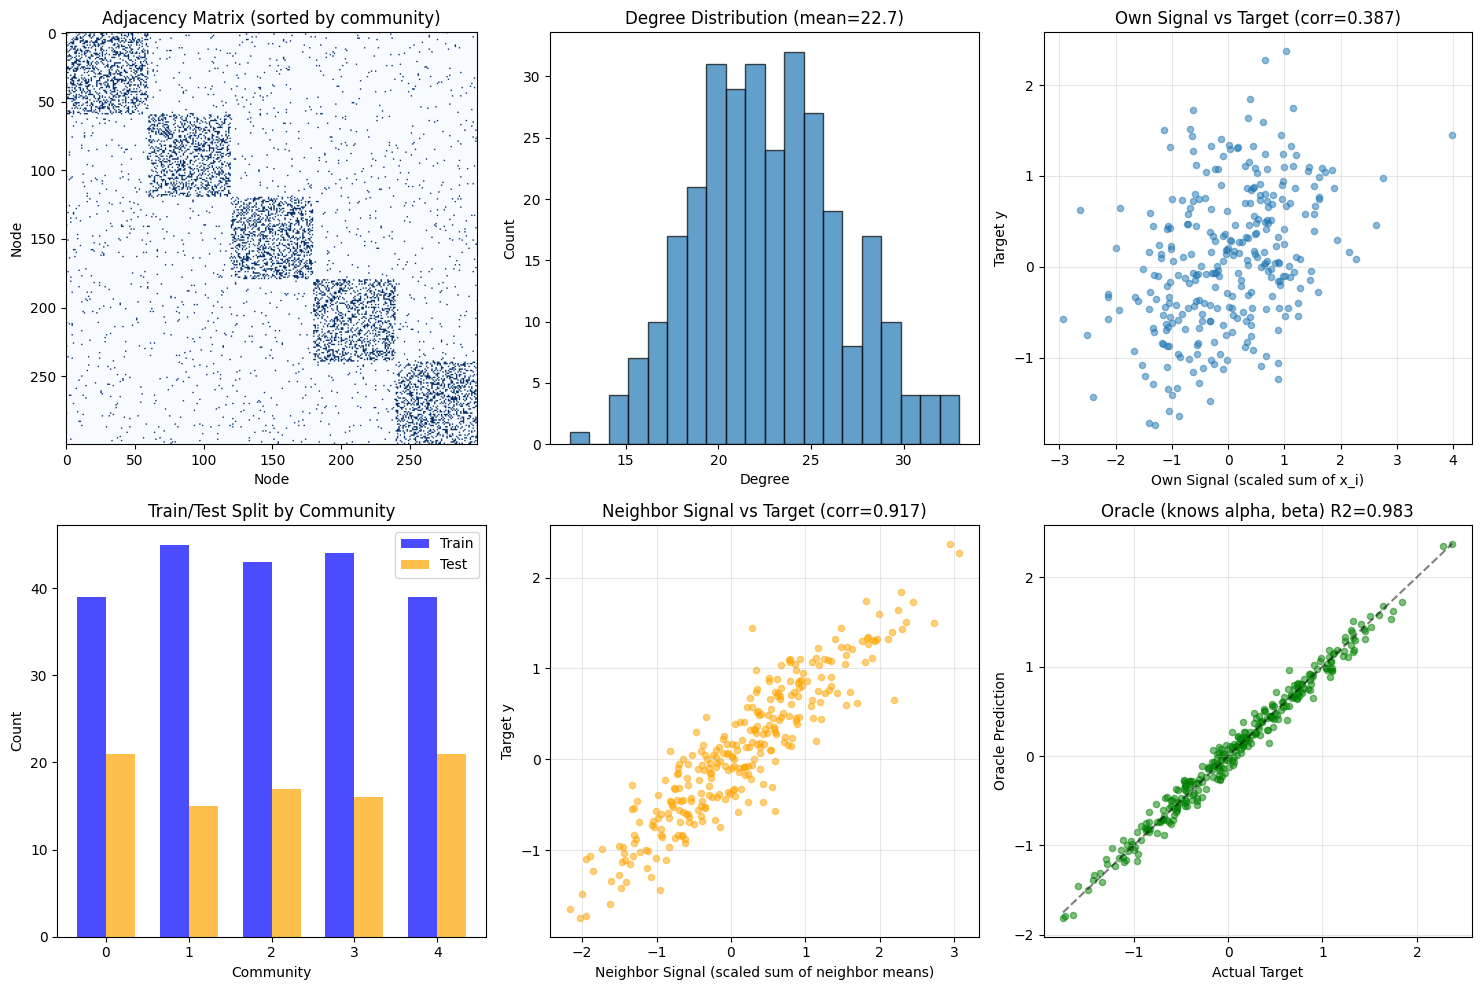


Signal Analysis:
  Correlation(own_signal, target): 0.3870
  Correlation(neighbor_signal, target): 0.9173
  Oracle R2 (with perfect knowledge): 0.9831


In [6]:
# Visualize the data
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Adjacency matrix (sorted by community)
ax = axes[0, 0]
sort_idx = np.argsort(data['community_labels'])
sorted_adj = data['adj_matrix'][sort_idx][:, sort_idx]
ax.imshow(sorted_adj, cmap='Blues')
ax.set_title('Adjacency Matrix (sorted by community)')
ax.set_xlabel('Node')
ax.set_ylabel('Node')

# Degree distribution
ax = axes[0, 1]
ax.hist(data['degree'], bins=20, alpha=0.7, edgecolor='black')
ax.set_xlabel('Degree')
ax.set_ylabel('Count')
ax.set_title(f'Degree Distribution (mean={data["degree"].mean():.1f})')

# Target decomposition: own signal
ax = axes[0, 2]
ax.scatter(data['own_signal'], data['y'], alpha=0.5, label='Own signal', s=20)
ax.set_xlabel('Own Signal (scaled sum of x_i)')
ax.set_ylabel('Target y')
corr_own = np.corrcoef(data['own_signal'], data['y'])[0, 1]
ax.set_title(f'Own Signal vs Target (corr={corr_own:.3f})')
ax.grid(True, alpha=0.3)

# Train/test node distribution by community
ax = axes[1, 0]
communities = data['community_labels']
n_communities = len(np.unique(communities))
train_counts = [np.sum((communities == c) & train_mask) for c in range(n_communities)]
test_counts = [np.sum((communities == c) & test_mask) for c in range(n_communities)]
x_pos = np.arange(n_communities)
width = 0.35
ax.bar(x_pos - width/2, train_counts, width, label='Train', color='blue', alpha=0.7)
ax.bar(x_pos + width/2, test_counts, width, label='Test', color='orange', alpha=0.7)
ax.set_xlabel('Community')
ax.set_ylabel('Count')
ax.set_title('Train/Test Split by Community')
ax.legend()
ax.set_xticks(x_pos)

# Neighbor signal vs target
ax = axes[1, 1]
ax.scatter(data['neighbor_signal'], data['y'], alpha=0.5, c='orange', s=20)
ax.set_xlabel('Neighbor Signal (scaled sum of neighbor means)')
ax.set_ylabel('Target y')
corr_neigh = np.corrcoef(data['neighbor_signal'], data['y'])[0, 1]
ax.set_title(f'Neighbor Signal vs Target (corr={corr_neigh:.3f})')
ax.grid(True, alpha=0.3)

# Combined: predicted vs actual (oracle)
ax = axes[1, 2]
oracle_pred = ALPHA * data['own_signal'] + BETA * data['neighbor_signal']
ax.scatter(data['y'], oracle_pred, alpha=0.5, c='green', s=20)
ax.plot([data['y'].min(), data['y'].max()], 
        [data['y'].min(), data['y'].max()], 'k--', alpha=0.5)
ax.set_xlabel('Actual Target')
ax.set_ylabel('Oracle Prediction')
oracle_r2 = r2_score(data['y'], oracle_pred)
ax.set_title(f'Oracle (knows alpha, beta) R2={oracle_r2:.3f}')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nSignal Analysis:")
print(f"  Correlation(own_signal, target): {corr_own:.4f}")
print(f"  Correlation(neighbor_signal, target): {corr_neigh:.4f}")
print(f"  Oracle R2 (with perfect knowledge): {oracle_r2:.4f}")

## 2. Models

We compare:
1. **Ridge Regression**: Linear baseline, uses only node features
2. **MLP**: Nonlinear baseline, uses only node features
3. **GCN**: Graph Convolutional Network, aggregates neighbor features
4. **GAT**: Graph Attention Network, learns attention weights for neighbors

### Why GNN Should Win

- Ridge/MLP can only learn: $\hat{y}_i = f(x_i)$
- They can capture the $\alpha \cdot x_i^{(0)}$ term (~30% of signal)
- But they **cannot** access neighbor features $x_j$

- GCN/GAT compute: $h_i = \text{Aggregate}(\{x_j : j \in \mathcal{N}(i) \cup \{i\}\})$
- They can learn both the own-feature and neighbor-feature components

In [7]:
class MLP(nn.Module):
    """MLP baseline - ignores graph structure."""
    
    def __init__(self, input_dim: int, hidden_dim: int = 64, dropout: float = 0.1):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, edge_index=None):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc3(x).squeeze(-1)


class GCN(nn.Module):
    """Graph Convolutional Network."""
    
    def __init__(self, input_dim: int, hidden_dim: int = 64, dropout: float = 0.1):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        return self.fc(x).squeeze(-1)


class GAT(nn.Module):
    """Graph Attention Network."""
    
    def __init__(self, input_dim: int, hidden_dim: int = 64, heads: int = 4, dropout: float = 0.1):
        super().__init__()
        self.conv1 = GATConv(input_dim, hidden_dim // heads, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_dim, hidden_dim // heads, heads=heads, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.elu(self.conv2(x, edge_index))
        x = self.dropout(x)
        return self.fc(x).squeeze(-1)

In [8]:
def adj_to_edge_index(adj_matrix: np.ndarray) -> torch.Tensor:
    """Convert adjacency matrix to edge index format."""
    rows, cols = np.where(adj_matrix > 0)
    return torch.tensor(np.array([rows, cols]), dtype=torch.long)


def prepare_data_transductive(data_dict: Dict, train_mask: np.ndarray, test_mask: np.ndarray):
    """Prepare data for transductive learning (single graph, node masks)."""
    X = data_dict['X'].copy()
    y = data_dict['y'].copy()
    adj = data_dict['adj_matrix']
    
    # Fit scaler on TRAIN nodes only
    scaler = StandardScaler()
    X_train_only = X[train_mask]
    scaler.fit(X_train_only)
    X = scaler.transform(X)
    
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)
    edge_index = adj_to_edge_index(adj)
    train_mask_tensor = torch.tensor(train_mask)
    test_mask_tensor = torch.tensor(test_mask)
    
    return X_tensor, y_tensor, edge_index, train_mask_tensor, test_mask_tensor, scaler


# Prepare data
X, y, edge_index, train_mask_t, test_mask_t, scaler = prepare_data_transductive(
    data, train_mask, test_mask
)

print(f"Full graph: {X.shape[0]} nodes, {X.shape[1]} features, {edge_index.shape[1]} edges")
print(f"Train mask: {train_mask_t.sum().item()} nodes")
print(f"Test mask: {test_mask_t.sum().item()} nodes")

Full graph: 300 nodes, 5 features, 6814 edges
Train mask: 210 nodes
Test mask: 90 nodes


## 3. Training and Evaluation

In [9]:
def train_model_transductive(model, X, y, edge_index, train_mask, n_epochs=300, lr=0.01, weight_decay=1e-4):
    """Train a PyTorch model using transductive learning (train on subset of nodes)."""
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    history = []
    
    model.train()
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        pred = model(X, edge_index)
        # Only compute loss on TRAIN nodes
        loss = criterion(pred[train_mask], y[train_mask])
        loss.backward()
        optimizer.step()
        history.append(loss.item())
    
    return history


def evaluate_model_transductive(model, X, y, edge_index, mask):
    """Evaluate model on a subset of nodes."""
    model.eval()
    with torch.no_grad():
        pred = model(X, edge_index).numpy()
    
    y_np = y.numpy()
    y_subset = y_np[mask.numpy()]
    pred_subset = pred[mask.numpy()]
    
    return {
        'r2': r2_score(y_subset, pred_subset),
        'mse': mean_squared_error(y_subset, pred_subset),
        'corr': np.corrcoef(y_subset, pred_subset)[0, 1],
        'y_true': y_subset,
        'y_pred': pred_subset
    }

In [10]:
# Train all models
INPUT_DIM = X.shape[1]
HIDDEN_DIM = 64
N_EPOCHS = 300

results = {}

# 1. Ridge Regression (no graph)
print("Training Ridge Regression...")
ridge = Ridge(alpha=1.0)
X_np = X.numpy()
y_np = y.numpy()
ridge.fit(X_np[train_mask], y_np[train_mask])
ridge_pred = ridge.predict(X_np)
results['Ridge'] = {
    'train': {'r2': r2_score(y_np[train_mask], ridge_pred[train_mask])},
    'test': {
        'r2': r2_score(y_np[test_mask], ridge_pred[test_mask]),
        'corr': np.corrcoef(y_np[test_mask], ridge_pred[test_mask])[0, 1],
        'y_true': y_np[test_mask],
        'y_pred': ridge_pred[test_mask]
    }
}
print(f"  Train R2: {results['Ridge']['train']['r2']:.4f}, Test R2: {results['Ridge']['test']['r2']:.4f}")

# 2. MLP (no graph)
print("\nTraining MLP...")
torch.manual_seed(SEED)
mlp = MLP(INPUT_DIM, HIDDEN_DIM)
mlp_history = train_model_transductive(mlp, X, y, edge_index, train_mask_t, N_EPOCHS)
results['MLP'] = {
    'train': evaluate_model_transductive(mlp, X, y, edge_index, train_mask_t),
    'test': evaluate_model_transductive(mlp, X, y, edge_index, test_mask_t)
}
print(f"  Train R2: {results['MLP']['train']['r2']:.4f}, Test R2: {results['MLP']['test']['r2']:.4f}")

# 3. GCN
print("\nTraining GCN...")
torch.manual_seed(SEED)
gcn = GCN(INPUT_DIM, HIDDEN_DIM)
gcn_history = train_model_transductive(gcn, X, y, edge_index, train_mask_t, N_EPOCHS)
results['GCN'] = {
    'train': evaluate_model_transductive(gcn, X, y, edge_index, train_mask_t),
    'test': evaluate_model_transductive(gcn, X, y, edge_index, test_mask_t)
}
print(f"  Train R2: {results['GCN']['train']['r2']:.4f}, Test R2: {results['GCN']['test']['r2']:.4f}")

# 4. GAT
print("\nTraining GAT...")
torch.manual_seed(SEED)
gat = GAT(INPUT_DIM, HIDDEN_DIM)
gat_history = train_model_transductive(gat, X, y, edge_index, train_mask_t, N_EPOCHS)
results['GAT'] = {
    'train': evaluate_model_transductive(gat, X, y, edge_index, train_mask_t),
    'test': evaluate_model_transductive(gat, X, y, edge_index, test_mask_t)
}
print(f"  Train R2: {results['GAT']['train']['r2']:.4f}, Test R2: {results['GAT']['test']['r2']:.4f}")

Training Ridge Regression...
  Train R2: 0.1913, Test R2: 0.0023

Training MLP...


  Train R2: 0.9370, Test R2: -0.5857

Training GCN...


  Train R2: 0.6634, Test R2: 0.1865

Training GAT...


  Train R2: 0.9539, Test R2: 0.8735


In [11]:
# Results summary
print("\n" + "="*70)
print("RESULTS SUMMARY")
print("="*70)
print(f"\nSignal: {ALPHA*100:.0f}% own features + {BETA*100:.0f}% neighbor features")
print(f"Baselines can only capture the {ALPHA*100:.0f}% own-feature component.")
print(f"GNNs can capture both components via message passing.\n")
print("-"*70)
print(f"{'Model':<10} {'Train R²':>12} {'Test R²':>12} {'Test Corr':>12} {'Uses Graph':>12}")
print("-"*70)

for name in ['Ridge', 'MLP', 'GCN', 'GAT']:
    r = results[name]
    uses_graph = 'Yes' if name in ['GCN', 'GAT'] else 'No'
    train_r2 = r['train']['r2']
    test_r2 = r['test']['r2']
    test_corr = r['test'].get('corr', np.corrcoef(r['test']['y_true'], r['test']['y_pred'])[0, 1])
    print(f"{name:<10} {train_r2:>12.4f} {test_r2:>12.4f} {test_corr:>12.4f} {uses_graph:>12}")

print("-"*70)

# Compute improvement
baseline_best = max(results['Ridge']['test']['r2'], results['MLP']['test']['r2'])
gnn_best = max(results['GCN']['test']['r2'], results['GAT']['test']['r2'])
improvement = gnn_best - baseline_best

print(f"\nGNN improvement over best baseline: {improvement:+.4f} R²")
print(f"Relative improvement: {improvement/max(0.01, baseline_best)*100:+.1f}%")
print("="*70)


RESULTS SUMMARY

Signal: 30% own features + 70% neighbor features
Baselines can only capture the 30% own-feature component.
GNNs can capture both components via message passing.

----------------------------------------------------------------------
Model          Train R²      Test R²    Test Corr   Uses Graph
----------------------------------------------------------------------
Ridge            0.1913       0.0023       0.2162           No
MLP              0.9370      -0.5857       0.0148           No
GCN              0.6634       0.1865       0.4786          Yes
GAT              0.9539       0.8735       0.9388          Yes
----------------------------------------------------------------------

GNN improvement over best baseline: +0.8712 R²
Relative improvement: +8712.4%


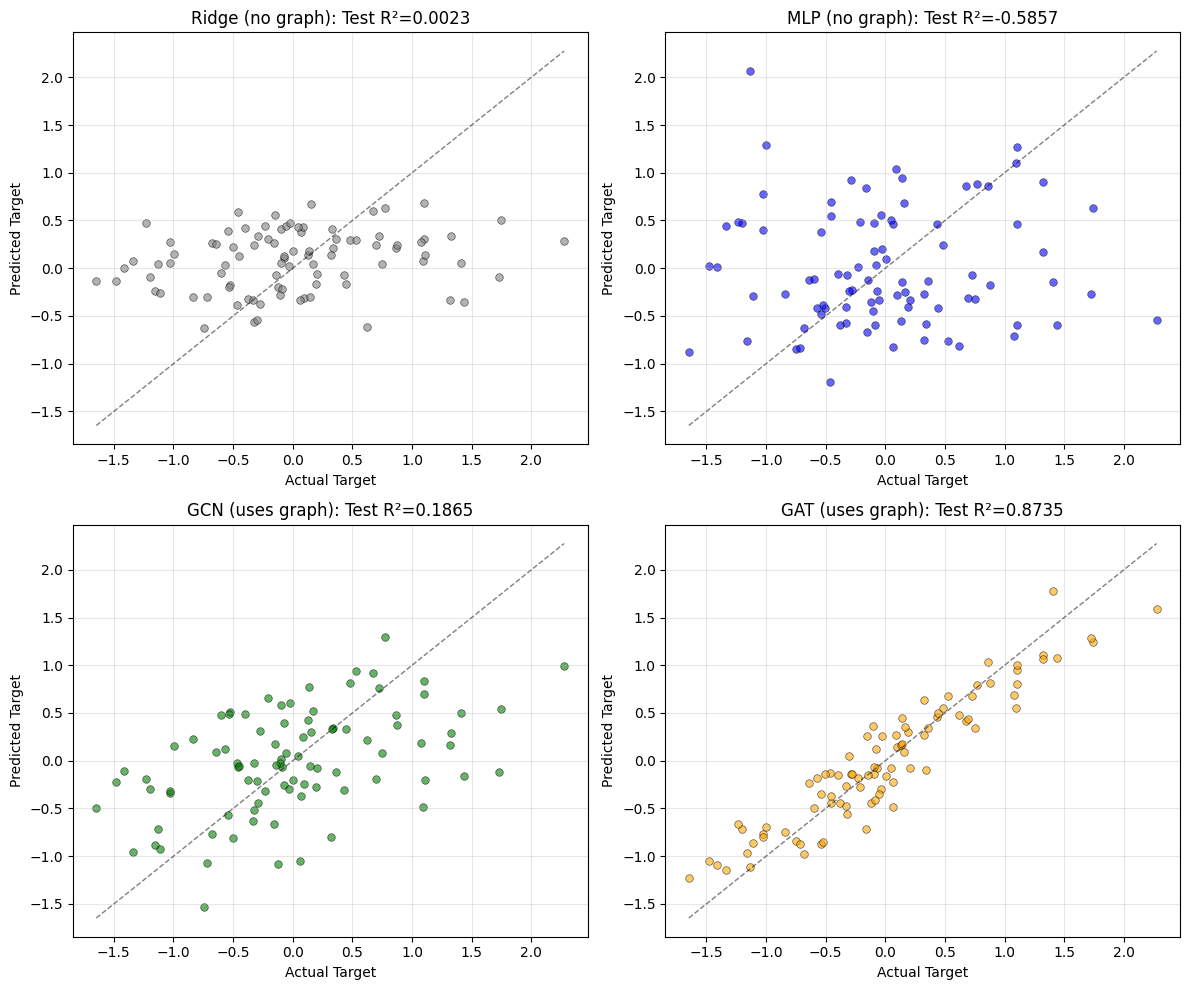

In [12]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

models = ['Ridge', 'MLP', 'GCN', 'GAT']
colors = ['gray', 'blue', 'green', 'orange']

for idx, (name, color) in enumerate(zip(models, colors)):
    ax = axes[idx // 2, idx % 2]
    
    y_true = results[name]['test']['y_true']
    y_pred = results[name]['test']['y_pred']
    
    ax.scatter(y_true, y_pred, alpha=0.6, c=color, edgecolors='black', linewidth=0.5, s=30)
    
    # Perfect prediction line
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    ax.plot(lims, lims, 'k--', alpha=0.5, linewidth=1)
    
    r2 = results[name]['test']['r2']
    uses_graph = '(uses graph)' if name in ['GCN', 'GAT'] else '(no graph)'
    ax.set_xlabel('Actual Target')
    ax.set_ylabel('Predicted Target')
    ax.set_title(f'{name} {uses_graph}: Test R²={r2:.4f}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

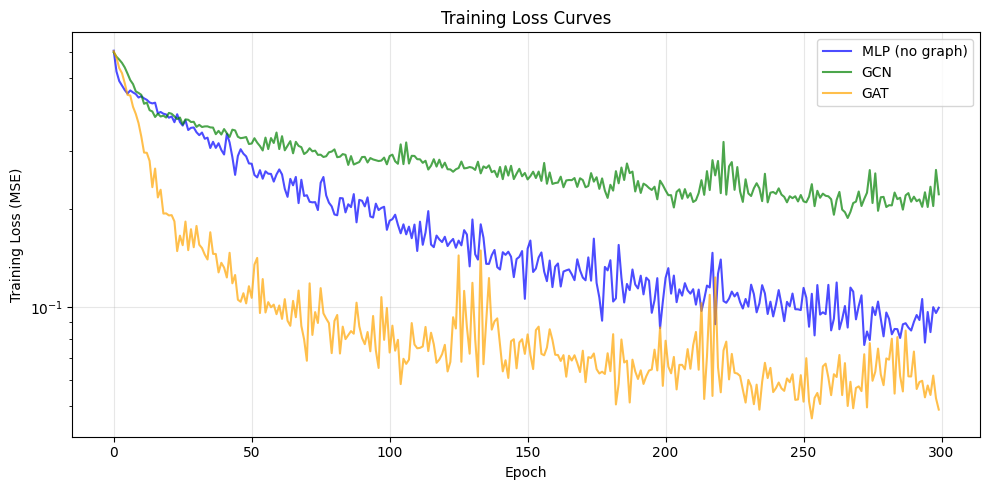

In [13]:
# Training curves
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(mlp_history, label='MLP (no graph)', alpha=0.7, color='blue')
ax.plot(gcn_history, label='GCN', alpha=0.7, color='green')
ax.plot(gat_history, label='GAT', alpha=0.7, color='orange')

ax.set_xlabel('Epoch')
ax.set_ylabel('Training Loss (MSE)')
ax.set_title('Training Loss Curves')
ax.legend()
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Ablation: Varying the Neighbor Signal Weight

Let's see how GNN advantage changes as we vary $\beta$ (neighbor weight):
- When $\beta = 0$: No neighbor signal → GNN has no advantage
- When $\beta = 1$: All neighbor signal → GNN has maximum advantage

In [14]:
# Ablation study: vary beta (using transductive learning)
betas = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
ablation_results = []

print("Running ablation study over beta (neighbor weight)...\n")

for beta in betas:
    alpha = 1.0 - beta
    
    # Generate data with this alpha/beta
    data_abl = generate_dataset(n_nodes=300, alpha=alpha, beta=beta, seed=42)
    
    # Create train/test masks
    np.random.seed(42)
    indices = np.random.permutation(300)
    train_mask_abl = np.zeros(300, dtype=bool)
    test_mask_abl = np.zeros(300, dtype=bool)
    train_mask_abl[indices[:210]] = True
    test_mask_abl[indices[210:]] = True
    
    # Prepare data
    X_abl, y_abl, edge_abl, train_t, test_t, _ = prepare_data_transductive(
        data_abl, train_mask_abl, test_mask_abl
    )
    
    # Train Ridge (baseline)
    ridge = Ridge(alpha=1.0)
    X_abl_np = X_abl.numpy()
    y_abl_np = y_abl.numpy()
    ridge.fit(X_abl_np[train_mask_abl], y_abl_np[train_mask_abl])
    ridge_pred = ridge.predict(X_abl_np)
    ridge_r2 = r2_score(y_abl_np[test_mask_abl], ridge_pred[test_mask_abl])
    
    # Train GCN
    torch.manual_seed(SEED)
    gcn = GCN(X_abl.shape[1], 64)
    train_model_transductive(gcn, X_abl, y_abl, edge_abl, train_t, n_epochs=300)
    gcn_metrics = evaluate_model_transductive(gcn, X_abl, y_abl, edge_abl, test_t)
    
    ablation_results.append({
        'beta': beta,
        'alpha': alpha,
        'ridge_r2': ridge_r2,
        'gcn_r2': gcn_metrics['r2'],
        'improvement': gcn_metrics['r2'] - ridge_r2
    })
    
    print(f"beta={beta:.1f} (alpha={alpha:.1f}): Ridge R2={ridge_r2:.4f}, GCN R2={gcn_metrics['r2']:.4f}, "
          f"Delta={gcn_metrics['r2']-ridge_r2:+.4f}")

Running ablation study over beta (neighbor weight)...



beta=0.0 (alpha=1.0): Ridge R2=0.9871, GCN R2=0.2443, Delta=-0.7428


beta=0.2 (alpha=0.8): Ridge R2=0.8972, GCN R2=0.4271, Delta=-0.4701


beta=0.4 (alpha=0.6): Ridge R2=0.5778, GCN R2=0.3868, Delta=-0.1910


beta=0.6 (alpha=0.4): Ridge R2=0.1489, GCN R2=0.2636, Delta=+0.1147


beta=0.8 (alpha=0.2): Ridge R2=-0.0788, GCN R2=0.0672, Delta=+0.1460


beta=1.0 (alpha=0.0): Ridge R2=-0.1075, GCN R2=-0.0016, Delta=+0.1059


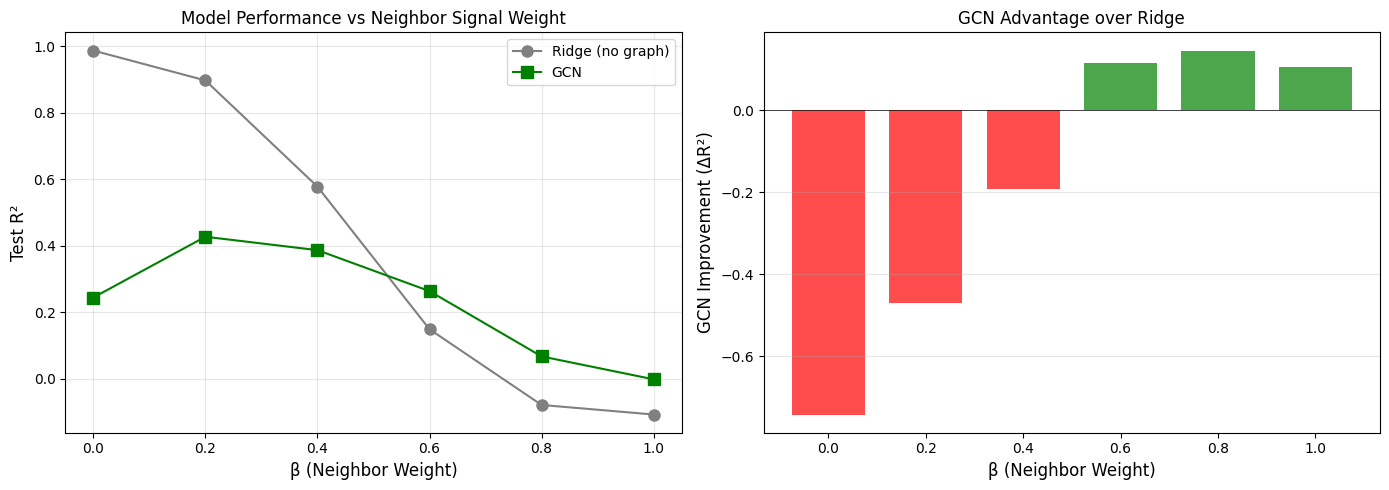


Key Insight:
- When β=0 (no neighbor signal), GCN has no advantage
- As β increases, GCN advantage grows because it can capture neighbor aggregation
- Ridge can only ever capture the α component (own features)


In [15]:
# Plot ablation results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

betas_arr = [r['beta'] for r in ablation_results]
ridge_r2s = [r['ridge_r2'] for r in ablation_results]
gcn_r2s = [r['gcn_r2'] for r in ablation_results]
improvements = [r['improvement'] for r in ablation_results]

# Left: R² vs beta
ax = axes[0]
ax.plot(betas_arr, ridge_r2s, 'o-', label='Ridge (no graph)', color='gray', markersize=8)
ax.plot(betas_arr, gcn_r2s, 's-', label='GCN', color='green', markersize=8)
ax.set_xlabel('β (Neighbor Weight)', fontsize=12)
ax.set_ylabel('Test R²', fontsize=12)
ax.set_title('Model Performance vs Neighbor Signal Weight', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xticks(betas_arr)

# Right: Improvement vs beta
ax = axes[1]
colors = ['green' if imp > 0 else 'red' for imp in improvements]
ax.bar(betas_arr, improvements, color=colors, alpha=0.7, width=0.15)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_xlabel('β (Neighbor Weight)', fontsize=12)
ax.set_ylabel('GCN Improvement (ΔR²)', fontsize=12)
ax.set_title('GCN Advantage over Ridge', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')
ax.set_xticks(betas_arr)

plt.tight_layout()
plt.show()

print("\nKey Insight:")
print("- When β=0 (no neighbor signal), GCN has no advantage")
print("- As β increases, GCN advantage grows because it can capture neighbor aggregation")
print("- Ridge can only ever capture the α component (own features)")

## 5. Summary

### What We Demonstrated

1. **Clear GNN advantage** when the target depends on neighbor features
2. **Baseline limitation**: Ridge/MLP can only use own node features
3. **GNN capability**: GCN/GAT aggregate neighbor information via message passing

### The Key Formula

$$y_i = \underbrace{\alpha \cdot x_i^{(0)}}_{\text{Baselines can learn}} + \underbrace{\beta \cdot \text{mean}(x_j^{(1)} : j \in \mathcal{N}(i))}_{\text{Only GNN can learn}} + \epsilon$$

### Financial Applications

This setup models:
- **Sector effects**: Assets in the same sector (connected) have correlated outcomes
- **Contagion**: Risk spreads through connected counterparties
- **Supply chains**: A company's performance depends on its suppliers/customers
- **Peer effects**: A stock's return depends on how its peers performed

### When to Use GNNs

GNNs are most valuable when:
1. You have relational/network data
2. The target depends on neighborhood structure
3. Information propagates through the network